In [2]:
# %pip install tensorflow
# %pip install numpy
# %pip install pandas
# %pip install matplotlib
# %pip install pydot

In [3]:
from PIL import Image
from pathlib import Path
import os

data_dir = "hair_types"
image_extensions = [".png", ".jpg", ".jpeg", ".bmp"]


def is_valid_image_pillow(file_name):
    try:
        with Image.open(file_name) as img:
            img.verify()
            img = Image.open(file_name)
            if not img.format.lower() in ['png', 'jpeg', 'bmp']:
                print(f"{file_name} is a {img.format}, not accepted by TensorFlow")
                os.remove(file_name)

    except (IOError, SyntaxError) as e:
        print(f"{file_name} is not an image")


for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        is_valid_image_pillow(filepath)
    else:
        print(f"{filepath} not in target extensions")

hair_types\Curly_Hair not in target extensions
hair_types\Straight_Hair not in target extensions
hair_types\Wavy_Hair not in target extensions
hair_types\Curly_Hair\rs_1080x1080-200330130638-1080-ariana-grande-curly-hair-instagram-am-033020.gif not in target extensions
hair_types\Straight_Hair\graphicstock-young-handsome-asiatic-long-brown-straight-hair-woman-taking-selfie-outdoor-in-the-city-with-a-smartphone-smiling-vanity-technology-social-network-concept_B6fyU2Ok-_SB_PM.jpg is not an image
hair_types\Straight_Hair\graphicstock-young-handsome-caucasian-reddish-straight-hair-woman-sitting-on-a-small-wall-holding-a-tablet-taking-a-selfie-doing-grimace-technology-social-network-youthful-concept_BTFpe2_1W_SB_PM.jpg is not an image


In [4]:
curly_hair_pics = [label for label in Path(data_dir).rglob("Curly_Hair/*")]
straight_hair_pics = [label for label in Path(
    data_dir).rglob("Straight_Hair/*")]
wavy_hair_pics = [label for label in Path(data_dir).rglob("Wavy_Hair/*")]

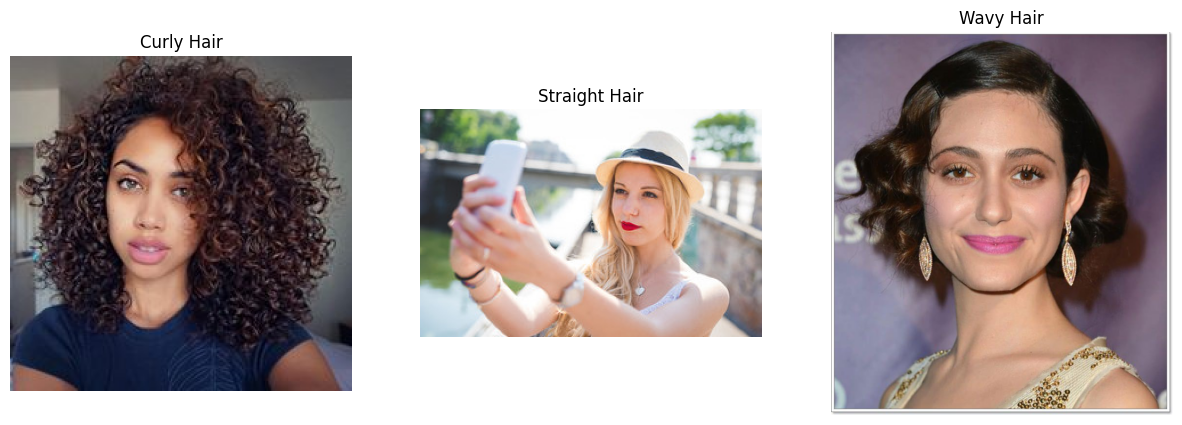

In [5]:
import matplotlib.pyplot as plt
from PIL import Image

img1 = Image.open(str(curly_hair_pics[0]))
img2 = Image.open(str(straight_hair_pics[0]))
img3 = Image.open(str(wavy_hair_pics[0]))

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img1)
plt.axis('off')
plt.title('Curly Hair')

plt.subplot(1, 3, 2)
plt.imshow(img2)
plt.axis('off')
plt.title('Straight Hair')

plt.subplot(1, 3, 3)
plt.imshow(img3)
plt.axis('off')
plt.title('Wavy Hair')

plt.show()

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

image_size = (128, 128)
batch_size = 16

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "hair_types/",
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
    labels='inferred',
    label_mode='categorical',
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "hair_types/",
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
    labels='inferred',
    label_mode='categorical'
)

Found 984 files belonging to 3 classes.
Using 788 files for training.
Found 984 files belonging to 3 classes.
Using 196 files for validation.


In [7]:
hair_types_labels = [label.replace("_", " ") for label in train_ds.class_names]

In [8]:
def apply_sobel_edges(images):
    sobel_edges = tf.image.sobel_edges(images)
    sobel_edges = tf.sqrt(tf.reduce_sum(tf.square(sobel_edges), axis=-1))

    return sobel_edges


def preprocessing(image, label):
    image = apply_sobel_edges(image)

    return image, label


train_ds = train_ds.map(preprocessing)
val_ds = val_ds.map(preprocessing)

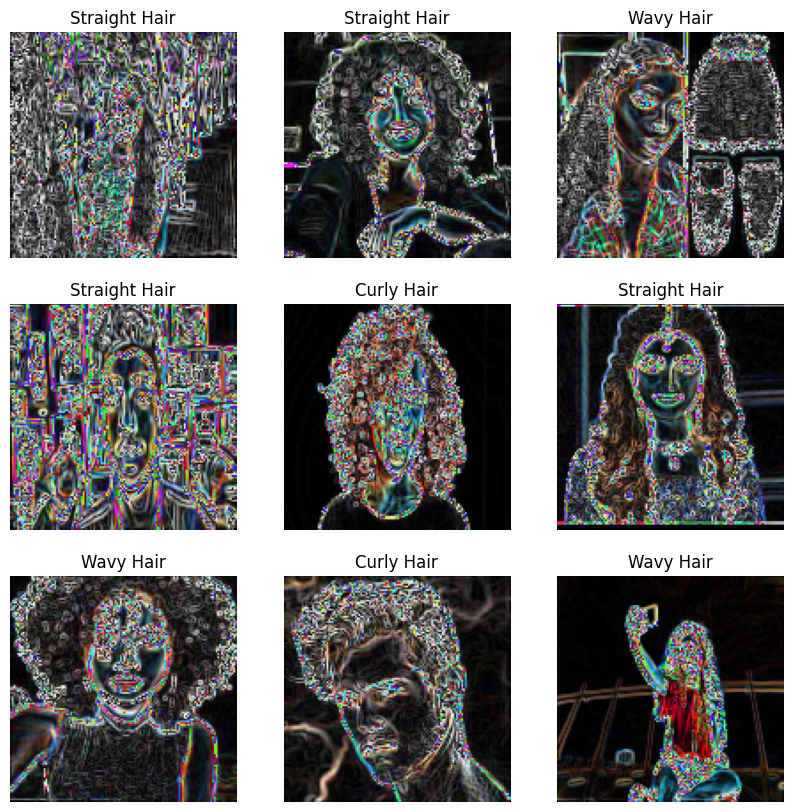

In [9]:
import numpy as np

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(hair_types_labels[int(np.argmax(labels[i]))])
        plt.axis("off")
plt.show()

In [121]:

from keras.models import Sequential

model = Sequential()
inputs = keras.Input(shape=image_size + (3,))
rescaling = layers.Rescaling(1.0/255)(inputs)

###
e1a = layers.Conv2D(filters=4, kernel_size=3,
                       strides=1, padding='valid', dilation_rate=1)(rescaling)
e1b = layers.Activation('relu')(e1a)
e1c = layers.Conv2D(filters=4, kernel_size=3,
                       strides=1, padding='valid', dilation_rate=1)(e1b)
e1d = layers.Activation('relu')(e1c)
e1e = layers.MaxPooling2D(2, 2)(e1d)

###
e2a = layers.Conv2D(filters=16, kernel_size=3,
                       strides=1, padding='valid', dilation_rate=1)(e1e)
e2b = layers.Activation('relu')(e2a)
e2c = layers.Conv2D(filters=16, kernel_size=3,
                       strides=1, padding='valid', dilation_rate=1)(e2b)
e2d = layers.Activation('relu')(e2c)
e2e = layers.MaxPooling2D(2, 2)(e2d)

###
e3a = layers.Conv2D(filters=32, kernel_size=3,
                       strides=1, padding='valid', dilation_rate=1)(e2e)
e3b = layers.Activation('relu')(e3a)
e3c = layers.Conv2D(filters=32, kernel_size=3,
                       strides=1, padding='valid', dilation_rate=1)(e3b)
e3d = layers.Activation('relu')(e3c)
e3e = layers.MaxPooling2D(2, 2)(e3d)

###
b1a = layers.Conv2D(filters=64, kernel_size=3,
                       strides=1, padding='valid', dilation_rate=1)(e3e)
b1b = layers.Activation('relu')(b1a)
b1c = layers.Conv2D(filters=64, kernel_size=3,
                       strides=1, padding='valid', dilation_rate=1)(b1b)
b1d = layers.Activation('relu')(b1c)

class Resize(keras.Layer):
    def call(self, x, y):
        return tf.image.resize(x, size=(y.shape[1], y.shape[2]))
###
d1a = layers.Conv2DTranspose(filters=32, kernel_size=3,
                             strides=1, padding='valid', dilation_rate=1)(b1d)
resz1 = Resize()(e3e, d1a)
conc1 = layers.Concatenate()([resz1, d1a])
d1b = layers.Conv2D(filters=32, kernel_size=3,
                    strides=1, padding='valid', dilation_rate=1)(conc1)
d1c = layers.Activation('relu')(d1b)
d1d = layers.Conv2D(filters=32, kernel_size=3,
                    strides=1, padding='valid', dilation_rate=1)(d1c)
d1e = layers.Activation('relu')(d1d)

##################################################

d2a = layers.Conv2DTranspose(filters=32, kernel_size=3,
                             strides=1, padding='valid', dilation_rate=1)(d1e)
resz2 = Resize()(e2e, d2a)
conc2 = layers.Concatenate()([resz2, d2a])
d2b = layers.Conv2D(filters=32, kernel_size=3,
                    strides=1, padding='valid', dilation_rate=1)(conc2)
d2c = layers.Activation('relu')(d2b)
d2d = layers.Conv2D(filters=32, kernel_size=3,
                    strides=1, padding='valid', dilation_rate=1)(d2c)
d2e = layers.Activation('relu')(d2d)

##################################################

d3a = layers.Conv2DTranspose(filters=32, kernel_size=3,
                             strides=1, padding='valid', dilation_rate=1)(d2e)
resz3 = Resize()(e1e, d3a)
conc3 = layers.Concatenate()([resz3, d3a])
d3b = layers.Conv2D(filters=32, kernel_size=3,
                    strides=1, padding='valid', dilation_rate=1)(conc3)
d3c = layers.Activation('relu')(d3b)
d3d = layers.Conv2D(filters=32, kernel_size=3,
                    strides=1, padding='valid', dilation_rate=1)(d3c)
d3e = layers.Activation('relu')(d3d)




# model.add(layers.Conv2D(filters=128, kernel_size=2,
#           strides=1, padding='valid', dilation_rate=1))
# model.add(layers.Activation('relu'))
# model.add(layers.BatchNormalization())
# model.add(layers.MaxPooling2D(2,2))
# model.add(layers.Dropout(0.25))


gap2d = layers.GlobalAveragePooling2D()(d3e)

dense = layers.Dense(512)(gap2d)
dropout = layers.Dropout(0.5)(dense)
relu = layers.Activation("relu")(dropout)

dense2 = layers.Dense(3)(relu)
outputs = layers.Activation("softmax")(dense2)

model = keras.Model(inputs=inputs, outputs=outputs)


# tf.keras.utils.plot_model(model, to_file='model_test.png', show_shapes=True)

In [122]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

model.summary()

Model: "functional_221"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_29 (InputLayer)   │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_28 (Rescaling)      │ (None, 128, 128, 3)       │               0 │ input_layer_29[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_268 (Conv2D)           │ (None, 126, 126, 4)       │             112 │ rescaling_28[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_228 (Activation)   │ (None, 126, 126, 4)       │               0 │ conv2d_268[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_269 (Conv2D)           │ (None, 124, 124, 4)       │             148 │ activation_228[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_229 (Activation)   │ (None, 124, 124, 4)       │               0 │ conv2d_269[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_81              │ (None, 62, 62, 4)         │               0 │ activation_229[0][0]       │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_270 (Conv2D)           │ (None, 60, 60, 16)        │             592 │ max_pooling2d_81[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_230 (Activation)   │ (None, 60, 60, 16)        │               0 │ conv2d_270[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_271 (Conv2D)           │ (None, 58, 58, 16)        │           2,320 │ activation_230[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_231 (Activation)   │ (None, 58, 58, 16)        │               0 │ conv2d_271[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_82              │ (None, 29, 29, 16)        │               0 │ activation_231[0][0]       │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_272 (Conv2D)           │ (None, 27, 27, 32)        │           4,640 │ max_pooling2d_82[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_232 (Activation)   │ (None, 27, 27, 32)        │               0 │ conv2d_272[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_273 (Conv2D)           │ (None, 25, 25, 32)        │           9,248 │ activation_232[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_233 (Activation)   │ (None, 25, 25, 32)        │               0 │ conv2d_273[0][0]           │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 198,343 (774.78 KB)

 Trainable params: 198,343 (774.78 KB)

 Non-trainable params: 0 (0.00 B)

In [123]:
from tensorflow.keras.callbacks import EarlyStopping

data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomTranslation(height_factor=0.2, width_factor=0.2)
])


augmented_train_ds = train_ds.map(

    lambda x, y: (data_augmentation(x, training=True), y))

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    mode='min',
    restore_best_weights=True)


epochs = 50

history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)
history

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.3107 - loss: 1.0991 - val_accuracy: 0.3163 - val_loss: 1.0988
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.3015 - loss: 1.0991 - val_accuracy: 0.3418 - val_loss: 1.0986
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.3384 - loss: 1.0987 - val_accuracy: 0.3367 - val_loss: 1.0986
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.3357 - loss: 1.0990 - val_accuracy: 0.3418 - val_loss: 1.0984
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.2860 - loss: 1.0996 - val_accuracy: 0.3520 - val_loss: 1.0986
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.3143 - loss: 1.0993 - val_accuracy: 0.3061 - val_loss: 1.0986
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.2904 - loss: 1.0990 - val_accuracy: 0.3163 - val_loss: 1.0988
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.3476 - loss: 1.0990 - val_accuracy: 0.3673 - v

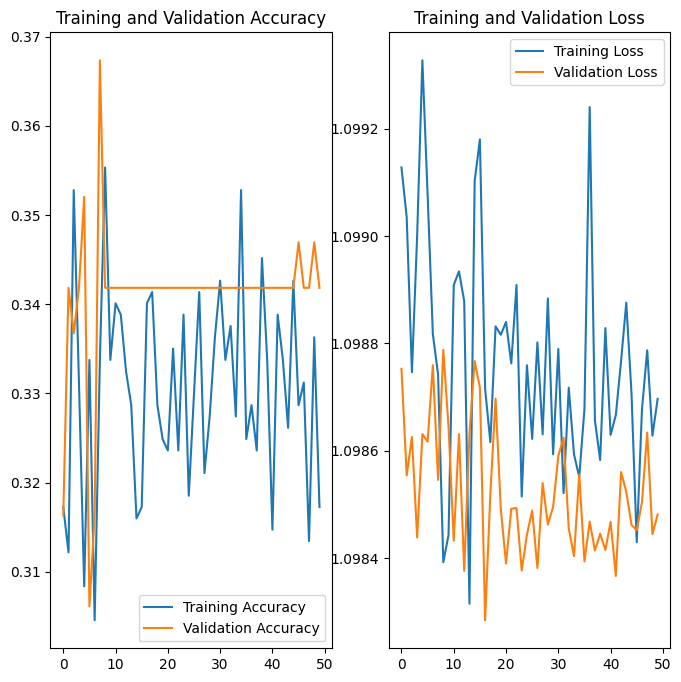

In [124]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [445]:
import numpy as np

true_labels = []
pred_labels = []

for images, labels in val_ds:
    true_labels.extend(np.argmax(labels.numpy(), axis=1))
    preds = model.predict(images)
    pred_labels.extend(np.argmax(preds, axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


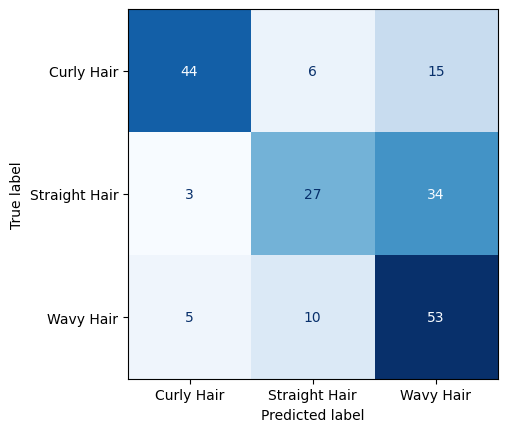

In [446]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

hair_labels_cm = ['Curly Hair', 'Straight Hair', 'Wavy Hair']

cm = confusion_matrix(true_labels, pred_labels)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=hair_labels_cm).plot(
    include_values=True, cmap='Blues', colorbar=False)

In [447]:
from sklearn.metrics import classification_report
import pandas as pd

class_report = classification_report(
    true_labels, pred_labels, target_names=hair_types_labels, output_dict=True)
report_df = pd.DataFrame(class_report).transpose()

report_df = report_df.drop(index=['accuracy', 'macro avg', 'weighted avg'])
report_df = report_df.round(2)

report_df

,precision,recall,f1-score,support
Curly Hair,0.85,0.68,0.75,65.0
Straight Hair,0.63,0.42,0.50,64.0
Wavy Hair,0.52,0.78,0.62,68.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
This image is 0.00 percent curly hair, 0.38 percent straight hair, and 0.62 percent wavy hair.


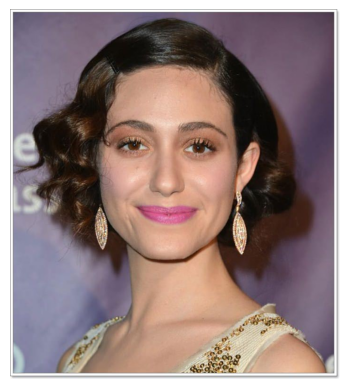

In [448]:
img_array = keras.preprocessing.image.img_to_array(img3)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
print(
    "This image is %.2f percent curly hair, %.2f percent straight hair, and %.2f percent wavy hair."
    % tuple(predictions[0])
)

plt.axis("off")
plt.imshow(img3)